In [1]:
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import ClassLabel
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
import nltk
import evaluate
import time


# fix seeding for pytorch and huggingface
import torch
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/iris/anaconda3/envs/cpkl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Deberta NLU Full Classifier

### Dataset Loader

In [2]:
# Dataset config
linking_data_path = "./dimiss_items/data/model_gpt-3.5-turbo-0125"
TRAIN_DATA_PATH = f'{linking_data_path}/processed/gpt_label_full_train_df.json'
VALID_DATA_PATH = f'{linking_data_path}/processed/gpt_label_full_valid_df.json'

DS_TYPE = "full"
USE_TAG = True

LABEL_TO_ID = {"entailment": 0, "not_entailment": 1}
ID_TO_LABEL = {0: "entailment", 1: "not_entailment"}

COMFACT_LABEL_TO_ID = {True: 0, False: 1} # comFactDataLabelToId

In [3]:
import re

def replace_phrases(sentence, person_a_tag):
    sentence = sentence.lower()
    # Pattern to find "I am" and replace with "person a is"
    sentence = re.sub(r"\bi am\b", f"{person_a_tag} is", sentence, flags=re.IGNORECASE)
    # Pattern to find "I was" and replace with "person a was"
    sentence = re.sub(r"\bi was\b", f"{person_a_tag} was", sentence, flags=re.IGNORECASE)
    sentence = re.sub(r"\bi\b", person_a_tag, sentence, flags=re.IGNORECASE)
    sentence = re.sub(r"\bmy\b", f"{person_a_tag}'s", sentence, flags=re.IGNORECASE)
    sentence = sentence.replace('person a', person_a_tag)
    return sentence


class DatasetLoader:
    def __init__(self, train_data_path: str, valid_data_path: str, ds_type: str, sample_size: int = None):
        self.train_data_path = train_data_path
        self.valid_data_path = valid_data_path
        self.sample_size = sample_size
        self.pa_tag, self.pb_tag = 'Person A', 'Person B'
        self.ds_type = ds_type

    def get_conv_from_text(self, example):
        center_utter = ""
        post_utters, future_utters = [], []
        for x in example['text']:
            if x['type'] == 'ut':
                center_utter = x['utter']
            elif '-' in x['type']:
                post_utters.append(x['utter'])
            elif '+' in x['type']:
                future_utters.append(x['utter'])

        convs_list = '\n'.join(post_utters + [center_utter] + future_utters)
        return convs_list

    def get_conv_with_tag_from_text(self, example):
        def format_utter(utter, tag):
            if utter.strip() == '':
                return ''
            return f"{tag}: {utter}"
        center_utter = ""
        post_utters, future_utters = [], []
        for x in example['text']:
            if x['type'] == 'ut':
                center_utter = format_utter(x['utter'], self.pa_tag)
            elif '-1' in x['type']:
                post_utters.append(format_utter(x['utter'], self.pb_tag))
            elif '-2' in x['type']:
                post_utters.append(format_utter(x['utter'], self.pa_tag)) 
            elif '+1' in x['type']:
                future_utters.append(format_utter(x['utter'], self.pb_tag)) 
            elif '+2' in x['type']:
                future_utters.append(format_utter(x['utter'], self.pa_tag)) 

        convs_list = '\n'.join(post_utters + [center_utter] + future_utters)
        return convs_list #.lower()

    def transform_df(self, df):
        df['conv'] = df.apply(self.get_conv_from_text, axis=1) if not USE_TAG else df.apply(self.get_conv_with_tag_from_text, axis=1)
        df['fact_text'] = df['fact_text'].apply(lambda x: x) if not USE_TAG else df['fact_text'].apply(lambda x: replace_phrases(x, self.pa_tag))
        df['labels'] = df['gold_reference'].apply(lambda x: COMFACT_LABEL_TO_ID[x])
        df['label_text'] = df['labels'].apply(lambda x: ID_TO_LABEL[x].lower())
        return df

    def create_pd_dataframe(self, data_path, sample_size=None):
        df = pd.read_json(data_path)
        # if self.ds_type == "relation":
        #     df['peacok_relation'] = df['relation']
        # if 'merged_head_tail' in data_path:
        #     df = self.modify_merged_head_tail(df)
        df = self.modify_merged_head_tail(df)
        df = df.sample(sample_size) if sample_size else df
        df = self.transform_df(df)
        return df

    def create_dataset(self, train_df, valid_df):
        train_ds = Dataset.from_pandas(train_df)
        valid_ds = Dataset.from_pandas(valid_df)

        dataset = DatasetDict({
            'train': train_ds,
            'valid': valid_ds
        })
        return dataset
    
    # def get_relation(self, df):
    #     return origonal_peacok_relation_df[origonal_peacok_relation_df['dialog_id'].isin(df['dialog_id'])]['peacok_relation']
    
    def modify_merged_head_tail(self, df):
        if self.ds_type == "head":
            df['gold_reference'] = df['gpt_tagged_head_gold_reference']
            df['fact_text'] = df['gpt_tagged_head_fact_text']
        elif self.ds_type == "tail":
            df['gold_reference'] = df['gpt_tagged_tail_gold_reference']
            df['fact_text'] = df['gpt_tagged_tail_fact_text']
        elif self.ds_type == "relation":
            # assert df['head_text'].equals(df['tail_text']), "head and tail text should be the same"
            # df['text'] = df['tail_text']
            df['gold_reference'] = df['gpt_tagged_head_gold_reference'] & df['gpt_tagged_tail_gold_reference']
            df['fact_text'] = df.apply(lambda x: f"{x['relation']} {x['gpt_tagged_head_fact_text']} and {x['gpt_tagged_tail_fact_text']}", axis=1)
            # df['fact_text'] = df.apply(lambda x: f"{x['head_fact_text']} and {x['tail_fact_text']}; {x['peacok_relation']}", axis=1)
        else:
            # assert df['head_text'].equals(df['tail_text']), "head and tail text should be the same"
            # df['text'] = df['tail_text']
            df['gold_reference'] = df['gpt_tagged_head_gold_reference'] & df['gpt_tagged_tail_gold_reference']
            df['fact_text'] = df.apply(lambda x: f"{x['gpt_tagged_head_fact_text']} and {x['gpt_tagged_tail_fact_text']}", axis=1)
        return df

    def load(self):
        train_df = self.create_pd_dataframe(self.train_data_path) # create_pd_dataframe(TRAIN_DATA_PATH, 5000)
        valid_df = self.create_pd_dataframe(self.valid_data_path) # create_pd_dataframe(VALID_DATA_PATH, 500)
        dataset = self.create_dataset(train_df, valid_df)
        return dataset

In [4]:
# load dataset
dataset_loader = DatasetLoader(TRAIN_DATA_PATH, VALID_DATA_PATH, DS_TYPE)
dataset = dataset_loader.load()

dataset

DatasetDict({
    train: Dataset({
        features: ['dialog_id', 'relation', 'head', 'tail', 'text', 'gpt_tagged_head_old_label', 'gpt_tagged_head_gpt_output', 'gpt_tagged_head_fact_text', 'gpt_tagged_head_gold_reference', 'gpt_tagged_tail_gpt_output', 'gpt_tagged_tail_old_label', 'gpt_tagged_tail_action', 'gpt_tagged_tail_fact_text', 'gpt_tagged_tail_gold_reference', 'gold_reference', 'fact_text', 'conv', 'labels', 'label_text', '__index_level_0__'],
        num_rows: 35821
    })
    valid: Dataset({
        features: ['dialog_id', 'relation', 'head', 'tail', 'text', 'gpt_tagged_head_old_label', 'gpt_tagged_head_gpt_output', 'gpt_tagged_head_fact_text', 'gpt_tagged_head_gold_reference', 'gpt_tagged_tail_gpt_output', 'gpt_tagged_tail_old_label', 'gpt_tagged_tail_action', 'gpt_tagged_tail_fact_text', 'gpt_tagged_tail_gold_reference', 'gold_reference', 'fact_text', 'conv', 'labels', 'label_text', '__index_level_0__'],
        num_rows: 3981
    })
})

In [5]:
# Use train_ds and valid_ds to get all unique relations for specical tokenization
relations_tokens = set(dataset['train']['relation'] + dataset['valid']['relation'])
relations_special_tokens = {'additional_special_tokens': list(relations_tokens)}
relations_special_tokens

{'additional_special_tokens': ['routine_habit_relationship',
  'experience',
  'characteristic',
  'goal_plan',
  'characteristic_relationship',
  'routine_habit',
  'experience_relationship',
  'goal_plan_relationship']}

In [6]:
from collections import Counter

counter = Counter([example['gold_reference'] for example in dataset['train']])
valid_counter = Counter([example['gold_reference'] for example in dataset['valid']])

print(f"{DS_TYPE} ds train len is {len(dataset['train'])}")
print(f"{DS_TYPE} Positive: {counter[True]}({counter[True]/len(dataset['train'])})")
print(f"{DS_TYPE} Negative: {counter[False]}({counter[False]/len(dataset['train'])})")
print()
print(f"{DS_TYPE} ds valid len is {len(dataset['valid'])}")
print(f"{DS_TYPE} Positive: {valid_counter[True]}({valid_counter[True]/len(dataset['valid'])})")
print(f"{DS_TYPE} Negative: {valid_counter[False]}({valid_counter[False]/len(dataset['valid'])})")

full ds train len is 35821
full Positive: 7922(0.22115518829736747)
full Negative: 27899(0.7788448117026325)

full ds valid len is 3981
full Positive: 863(0.2167797035920623)
full Negative: 3118(0.7832202964079377)


In [7]:
print(dataset['train'][0]['conv'], '\n')
print(dataset['train'][0]['gpt_tagged_tail_fact_text'])
print(dataset['train'][0]['gpt_tagged_head_fact_text'])
print(dataset['train'][0]['gpt_tagged_tail_action'])
print(dataset['train'][0]['relation'])
print(dataset['train'][0]['fact_text'])

Person A: i don't have hair. i want to go to vegas. how are you? just to let you know i'm single.
Person B: are you male or female? i can not wait to go back to school. do you use a wig? winter and fall is my favorite season
Person A: i saw a wig on netflix. fall isn't that good. male, college? you do sleeping in? i do
Person B: my sister loves me, and i love her. we are best friends. why not? does it get you down?
Person A: it is just that in vegas fall causes weird people to come out. you saw right? i'm happy for you. love is so hard to come by. 

am always there for friends
Person A is a loyal person
None
routine_habit_relationship
Person A is a loyal Person And am always there for friends


### Load Model

In [8]:
# Load model config
IS_TRAIN_SAMPLED = False
MODEL_SIZE = "large"
MODEL_NAME = f"microsoft/deberta-v3-{MODEL_SIZE}"
# MODEL_NAME = f"MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33"
OUTPUT_DIR = f"./dimiss_items/model/{DS_TYPE}/deberta-v3-{MODEL_SIZE}-{str(int(time.time()))}/"

print(f"""
- Model Name: {MODEL_NAME}
- Model Size: {MODEL_SIZE}
- Ds Type: {DS_TYPE}
- Output Dir: {OUTPUT_DIR}
""")

import wandb
wandb.init(project=f"cpkl-{DS_TYPE}-{MODEL_NAME.replace('/', '-')}", name=f"deberta-v3-{MODEL_SIZE}-{DS_TYPE}")


- Model Name: microsoft/deberta-v3-large
- Model Size: large
- Ds Type: full
- Output Dir: ./dimiss_items/model/full/deberta-v3-large-1720902951/



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: irislin1006. Use `wandb login --relogin` to force relogin


In [9]:
def load_model_and_tokenizer(model_name, label2id, id2label):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, model_max_length=512)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, label2id=label2id, id2label=id2label)
    
    if DS_TYPE == "relation":
        tokenizer.add_special_tokens(relations_special_tokens)
        model.resize_token_embeddings(len(tokenizer))
    return model, tokenizer

In [10]:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False, model_max_length=512)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, label2id=label2id, id2label=id2label)
model, tokenizer = load_model_and_tokenizer(MODEL_NAME, LABEL_TO_ID, ID_TO_LABEL)

/home/iris/anaconda3/envs/cpkl/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare Dataset for trainer

In [11]:
def tokenize_function(examples):
   return tokenizer(examples["conv"], examples["fact_text"], padding=True, truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=[
   'dialog_id', 
   'text',
   'relation',
   'head',
   'tail',
   'gpt_tagged_head_old_label', 
   'gpt_tagged_head_gold_reference', 
   'gpt_tagged_head_fact_text', 
   'gpt_tagged_head_gpt_output', 
   'gpt_tagged_tail_old_label', 
   'gpt_tagged_tail_gold_reference', 
   'gpt_tagged_tail_fact_text', 
   'gpt_tagged_tail_gpt_output', 
   'gpt_tagged_tail_action', 
   'fact_text', 
   'gold_reference', 
   'conv',
   '__index_level_0__'])
print(f"Using {DS_TYPE} Dataset. Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Map: 100%|██████████| 3981/3981 [00:01<00:00, 2728.95 examples/s]

Using full Dataset. Keys of tokenized dataset: ['labels', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask']


### Train model

In [12]:
# Prepare trainer

acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
roc_auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_preds):
    labels = eval_preds.label_ids
    pred_logits = eval_preds.predictions
    preds_max = np.argmax(pred_logits, axis=1)  # argmax on each row (axis=1) in the tensor
    pred_probs = torch.softmax(torch.tensor(pred_logits), dim=1)[:, 0].numpy()
      
    print("Number of predictions: ", len(preds_max))
    # compute f1, precision, recall, and accuracy 
    result = {}
    result.update(acc.compute(predictions=preds_max, references=labels))
    result.update(f1.compute(predictions=preds_max, references=labels, average='binary', pos_label=0))
    result.update(precision.compute(predictions=preds_max, references=labels, average='binary', pos_label=0))
    result.update(recall.compute(predictions=preds_max, references=labels, average='binary', pos_label=0))
    result.update(roc_auc_score.compute(prediction_scores=pred_probs, references=1-labels))
    return result

In [13]:
def get_trainer_args(output_dir):
    if DS_TYPE == "full":
        eval_steps=1500
        save_steps=1500
    elif DS_TYPE == "head":
        eval_steps=3000
        save_steps=3000
    elif DS_TYPE == "tail":
        eval_steps=3000
        save_steps=3000
    elif DS_TYPE == "relation":
        # eval_steps=500
        # save_steps=500
        eval_steps=1500
        save_steps=1500
    else:
        raise ValueError(f"'{DS_TYPE}' is invalid dataset type. Must be one of 'full', 'head', 'tail'")
    
    return TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        bf16 =False, # Overflows with bf16 
        learning_rate=1e-6,
        warmup_ratio=0.01,
        weight_decay=0.01,
        num_train_epochs=3,
        # logging & evaluation strategies
        logging_dir=f"{output_dir}/logs",
        logging_strategy="steps", 
        logging_steps=20,
        evaluation_strategy="steps",
        eval_steps=eval_steps,
        save_strategy="steps",
        save_steps=save_steps,
        save_total_limit=5,
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc",
        # push to hub parameters
        report_to="wandb",
    )

In [14]:
def get_trainer(model, tokenized_dataset, output_dir):
    training_args = get_trainer_args(output_dir)
    trainer =Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["valid"],
        compute_metrics=compute_metrics,
    )
    return trainer

trainer = get_trainer(model, tokenized_dataset, OUTPUT_DIR)

In [15]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1500,0.384500,0.379521,0.829942,0.594368,0.615385,0.574739,0.839851
3000,0.364400,0.392636,0.849284,0.644550,0.659394,0.630359,0.879558
4500,0.383600,0.385900,0.823160,0.661213,0.565432,0.796060,0.891049
6000,0.308900,0.350454,0.854810,0.662383,0.667845,0.657010,0.896535
7500,0.323600,0.370420,0.848279,0.673866,0.630940,0.723059,0.899742
9000,0.425100,0.386053,0.840744,0.671162,0.607512,0.749710,0.899817
10500,0.400400,0.378238,0.857322,0.671676,0.670127,0.673233,0.902889
12000,0.284800,0.398616,0.852801,0.675885,0.646561,0.707995,0.901855


Number of predictions:  3981
Number of predictions:  3981
Number of predictions:  3981
Number of predictions:  3981
Number of predictions:  3981
Number of predictions:  3981
Number of predictions:  3981
Number of predictions:  3981


TrainOutput(global_step=13434, training_loss=0.3835945605912236, metrics={'train_runtime': 6941.5643, 'train_samples_per_second': 15.481, 'train_steps_per_second': 1.935, 'total_flos': 5.205505592381522e+16, 'train_loss': 0.3835945605912236, 'epoch': 3.0})

Number of predictions:  3981


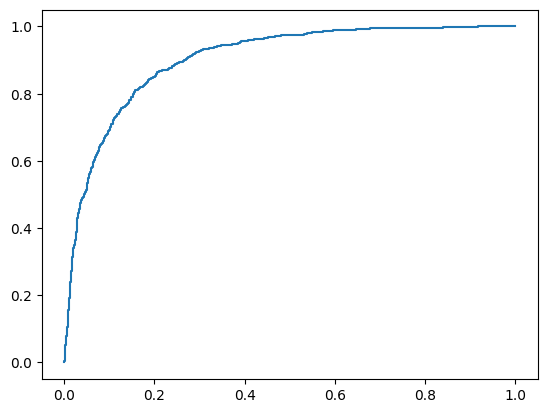

In [16]:
# plot a roc curve with sk learn  and matplot lib
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(trainer, tokenized_dataset):
    output = trainer.predict(tokenized_dataset["valid"])
    labels = 1 - output.label_ids
    pred_logits = output.predictions
    pred_probs = torch.softmax(torch.tensor(pred_logits), dim=1)[:, 0].numpy()
    fpr, tpr, thresholds = roc_curve(labels, pred_probs, pos_label=1)
    plt.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.2f})")
    return pred_probs, thresholds

pred_probs, thres = plot_roc_curve(trainer, tokenized_dataset)

In [17]:
# compute f1, precision, recall, and accuracy by given threshold
def compute_metrics_with_threshold(pred_probs, thres, labels):
    preds = (pred_probs > thres).astype(int)
    result = {}
    result.update(acc.compute(predictions=preds, references=labels))
    result.update(f1.compute(predictions=preds, references=labels, average='binary', pos_label=1))
    result.update(precision.compute(predictions=preds, references=labels, average='binary', pos_label=1))
    result.update(recall.compute(predictions=preds, references=labels, average='binary', pos_label=1))
    result.update(roc_auc_score.compute(prediction_scores=pred_probs, references=labels))
    return result

for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    print(f"Threshold: {t}")
    print(compute_metrics_with_threshold(pred_probs, t, 1 - np.array(tokenized_dataset["valid"]["labels"]).astype(int)))

Threshold: 0.2
{'accuracy': 0.8480281336347651, 'f1': 0.6834118262689691, 'precision': 0.6230916030534351, 'recall': 0.7566628041714948, 'roc_auc': 0.9028888441278801}
Threshold: 0.3
{'accuracy': 0.8543079628234111, 'f1': 0.680968096809681, 'precision': 0.6481675392670158, 'recall': 0.7172653534183082, 'roc_auc': 0.9028888441278801}
Threshold: 0.4
{'accuracy': 0.8558151218286862, 'f1': 0.6742338251986381, 'precision': 0.660734149054505, 'recall': 0.6882966396292005, 'roc_auc': 0.9028888441278801}
Threshold: 0.5
{'accuracy': 0.8573222808339613, 'f1': 0.6716763005780347, 'precision': 0.6701268742791234, 'recall': 0.6732329084588644, 'roc_auc': 0.9028888441278801}
Threshold: 0.6
{'accuracy': 0.8580758603365989, 'f1': 0.6686217008797654, 'precision': 0.6769596199524941, 'recall': 0.660486674391657, 'roc_auc': 0.9028888441278801}
Threshold: 0.7
{'accuracy': 0.8605877920120573, 'f1': 0.6682606096832039, 'precision': 0.6901234567901234, 'recall': 0.6477404403244496, 'roc_auc': 0.9028888441278

### Save Trained Model

In [18]:
OUTPUT_DIR

'./dimiss_items/model/full/deberta-v3-large-1720902951/'

In [19]:
def save_model(model, tokenizer, output_dir):
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
# OUTPUT_DIR = 'agents/dimiss_items/model/full/deberta-v3-large-1710086328/'
save_model_path = OUTPUT_DIR + f"deberta_v3_large_sample_{IS_TRAIN_SAMPLED}"
save_model(model, tokenizer, save_model_path)